# 1

In [ ]:
events = xml_processor.events['Name'].values
unique_events = np.unique(events)
print(unique_events)

print(psg_processor.start_datetime)
print(psg_processor.end_datetime)

In [ ]:
event_type = 'Obstructive Apnea'
event_df = df_sleep_events[df_sleep_events['Name'].str.contains(event_type)]
event_df

# 2024-06-21 03:33:36.600	2024-06-21 03:33:54.830
start_datetime = datetime(2024, 6, 20, 22, 2, 35)
end_datetime = datetime(2024, 6, 21, 5, 54, 58) 

filtered_df = df.loc[start_datetime:end_datetime]
# Make a df subset with all the columns except: 
# 'ECG', 'Thor', 'Movement Time (MT)', 'Wakefulness (W)', 'NREM Sleep Stage 1 (N1)', 
# 'REM Sleep', 'NREM Sleep Stage 2 (N2)', 'NREM Sleep Stage 3 (N3)'
columns_to_drop = ['Movement Time (MT)', 'Wakefulness (W)', 'NREM Sleep Stage 1 (N1)', 'REM Sleep', 'NREM Sleep Stage 2 (N2)', 'NREM Sleep Stage 3 (N3)']
df_subset = filtered_df.drop(columns=columns_to_drop)
print(df_subset.head())


In [ ]:
# Initialize the dictionary to hold the 3-level structure
structured_data = {}

# Ensure the 'Start' and 'End' times in xml_processor.events are in datetime format
# Assuming 'Start' and 'End' are already in datetime or timedelta format
events_df = xml_processor.events

# Iterate over each unique event type
for event_type in events_df['Name'].unique():
    # Filter the events of this type
    event_occurrences = events_df[events_df['Name'] == event_type]
    
    # Initialize a list to hold all occurrences for this event type
    occurrences_list = []
    
    # Iterate over each occurrence of this event type
    for _, event_row in event_occurrences.iterrows():
        start_time = event_row['Start']
        end_time = event_row['End']
        
        # Extract the relevant rows from df_subset for ECG and Thor within the time range
        relevant_data = df_subset[(df_subset.index >= start_time) & (df_subset.index <= end_time)][['ECG', 'Thor']]
        
        # Add the relevant data for this occurrence
        occurrences_list.append({
            'Start': start_time,
            'End': end_time,
            'ECG': relevant_data['ECG'].values,
            'Thor': relevant_data['Thor'].values,
            'Time': relevant_data.index
        })
    
    # Store the list of occurrences for this event type
    structured_data[event_type] = occurrences_list

# Example: Access data for a specific event type
# structured_data['Mixed Apnea'] will give you the occurrences and corresponding ECG/Thor data


In [ ]:
def plot_event_data(event_type):
    # Check if the event_type exists in the structured_data
    if event_type not in structured_data:
        print(f"Event type '{event_type}' not found in structured data.")
        return
    
    # Retrieve all occurrences for the given event type
    event_data = structured_data[event_type]
    
    # Iterate over each occurrence and plot ECG and Thor data
    for i, occurrence in enumerate(event_data):
        # Create subplots for ECG and Thor
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 4))  # 2 rows, 1 column

        # Plot ECG
        ax1.plot(occurrence['Time'], occurrence['ECG'], label='ECG')
        ax1.set_title(f'{event_type} - ECG (# {i + 1})')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('ECG Value')
        ax1.legend()

        # Plot Thor
        ax2.plot(occurrence['Time'], occurrence['Thor'], label='Thor')
        ax2.set_title(f'{event_type} - Thor (# {i + 1})')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Thor Value')
        ax2.legend()

        plt.tight_layout()  # Adjust spacing between subplots
        plt.show()  # Display the plot

In [ ]:
# Example usage:
event_type_name = "Central Apnea"  # Replace with the event type you want to plot
plot_event_data(event_type_name)


# 2

In [ ]:
df_sleep_stages = xml_processor.sleep_stages

start_datetime = psg_processor.start_datetime
end_datetime = psg_processor.end_datetime

filtered_df = df.loc[start_datetime:end_datetime]
df_subset = filtered_df[['ECG', 'Thor']]
print(df_subset.head())

In [ ]:
def add_sleep_stage_column(df_subset, df_sleep_stages):
    # Create a new column in df_subset to store the sleep stage code
    df_subset['Stage Code'] = None

    # Iterate over each row in df_sleep_stages
    for index, row in df_sleep_stages.iterrows():
        stage_start_time = row['Start Time']
        stage_end_time = stage_start_time + timedelta(seconds=30)

        # Find the rows in df_subset that fall within the current sleep stage interval
        mask = (df_subset.index >= stage_start_time) & (df_subset.index < stage_end_time)
        
        # Assign the sleep stage code to the corresponding rows in df_subset
        df_subset.loc[mask, 'Stage Code'] = row['Sleep Stage Code']
        # df_subset.loc[mask, 'Sleep Stage'] = row['Sleep Stage']
        # df_subset.loc[mask, 'Time (seconds)'] = row['Time (seconds)']
        # df_subset.loc[mask, 'Duration'] = row['Duration']
    
    return df_subset

# Example usage
# Apply the function to add the sleep stage column
df_subset_with_sleep_stage = add_sleep_stage_column(df_subset, df_sleep_stages)

print(df_subset_with_sleep_stage)
print(df_subset_with_sleep_stage['Stage Code'].value_counts())

In [ ]:
events1 = nk.events_find(df_subset_with_sleep_stage['Stage Code'], threshold=0, threshold_keep='below')
events2 = nk.events_find(df_subset_with_sleep_stage['Stage Code'], threshold=0, threshold_keep='above')


# Combine the arrays
combined_onset = np.concatenate((events1['onset'], events2['onset']))
combined_duration = np.concatenate((events1['duration'], events2['duration']))

# Sort the arrays based on the combined onset values
sorted_indices = np.argsort(combined_onset)
sorted_onset = combined_onset[sorted_indices]
sorted_duration = combined_duration[sorted_indices]
sorted_label = [str(i+1) for i in range(len(sorted_onset))]


# Create the merged dictionary
merged_events = {
    'onset': sorted_onset,
    'duration': sorted_duration,
    'label': sorted_label
}

print(merged_events)

In [ ]:
# Process the signal
data_clean, info = nk.bio_process(ecg=df_subset_with_sleep_stage["ECG"], 
                                  rsp=df_subset_with_sleep_stage["Thor"],
                                  keep=df_subset_with_sleep_stage["Stage Code"],  
                                  sampling_rate=1024)

# Visualize some of the channels
data_clean[["ECG_Rate", "RSP_Rate", "Stage Code"]].plot(subplots=True)

In [ ]:
plot = nk.events_plot(merged_events,data_clean[["ECG_Rate", "RSP_Rate", "Stage Code"]])


In [ ]:
epochs = nk.epochs_create(data_clean, merged_events, sampling_rate=1024, epochs_start=0, epochs_end='from_events')


In [ ]:
nk.rsp_intervalrelated(epochs)

In [ ]:
nk.ecg_intervalrelated(epochs)

In [ ]:
epochs = nk.epochs_create(data_clean, merged_events, sampling_rate=1024, epochs_start=-30, epochs_end=30)
# Iterate through epoch data
for epoch in epochs.values():
    # Plot scaled signals, "Stage Code"
    nk.signal_plot(epoch[['ECG_Rate', 'RSP_Rate']], 
                   title=epoch['Label'].values[0],  # Extract condition name
                   standardize=True)  

# 3

In [1]:
# main.py

from cw_radar import *
# from utils import extract_data_subset
# from camera_data_extraction import CameraDataProcessor
# from cw_data_extraction import CWDataProcessor
from datetime import datetime


# Example usage of CWDataProcessor
file_path = "/opt/data/private/ZhouWenren/SleepLab/cw_radar/radar20240620220948433561.csv"
sample_rate = 1000

# Create an instance of the CWDataProcessor
cw_processor = CWDataProcessor(file_path, sample_rate)

# Load the data from the specified file
cw_processor.load_data()
print(cw_processor.data.head())

# Define start and end datetime objects
start_datetime = datetime.strptime('20240620221033', '%Y%m%d%H%M%S')
end_datetime = datetime.strptime('20240620221133', '%Y%m%d%H%M%S')


Start time: 220948
Sample rate: 1000 Hz
                   timestamp  data_i  data_q
0 2024-06-20 22:09:48.435561  -0.033  -0.011
1 2024-06-20 22:09:48.437561  -0.034  -0.011
2 2024-06-20 22:09:48.438562  -0.034  -0.011
3 2024-06-20 22:09:48.438562  -0.035  -0.010
4 2024-06-20 22:09:48.439562  -0.035  -0.011


In [2]:
data_subset = extract_data_subset(cw_processor.data, start_datetime, end_datetime)


In [3]:
first_timestamp = data_subset.iloc[0]['timestamp']
last_timestamp = data_subset.iloc[-1]['timestamp']

print("First Timestamp:", first_timestamp)
print("Last Timestamp:", last_timestamp)

First Timestamp: 2024-06-20 22:10:33.001129
Last Timestamp: 2024-06-20 22:11:32.998687


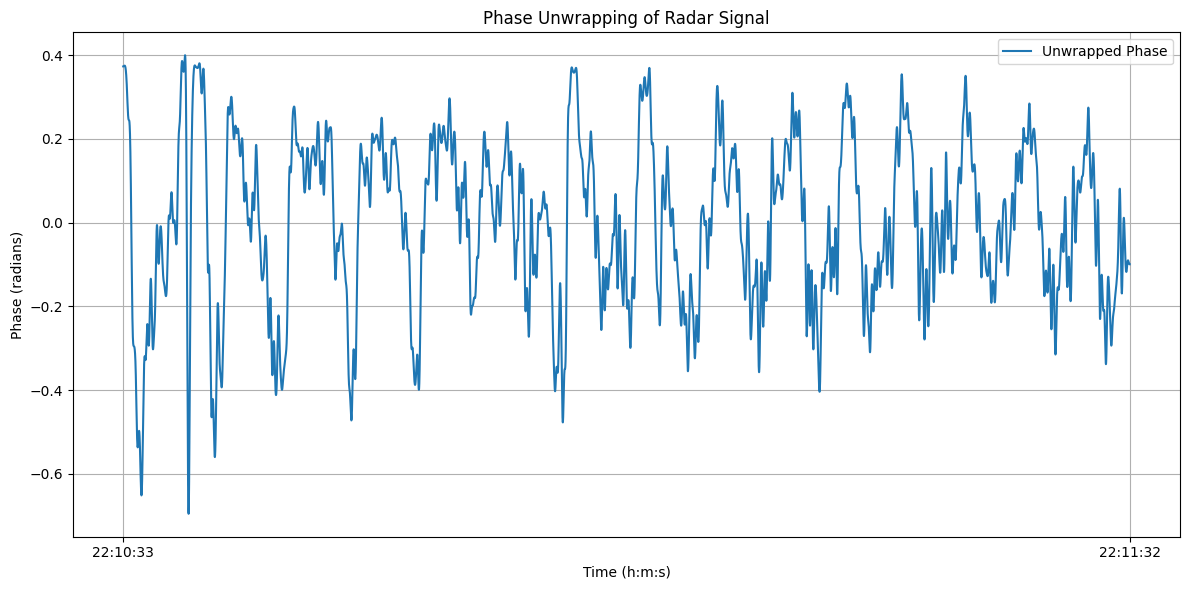

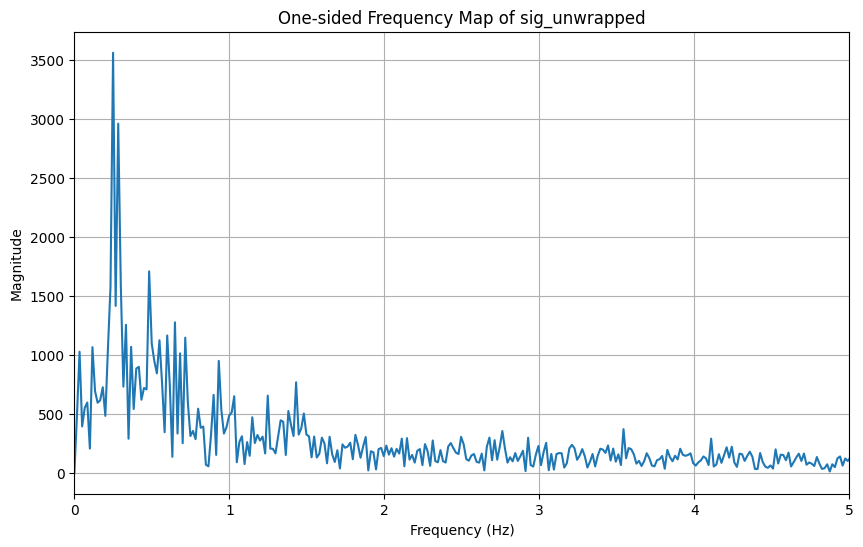

In [5]:
# Plot the processed radar data
cw_processor.plot_processed_data(data_subset)

# Frequency analysis: FFT plot
cw_processor.plot_frequency_analysis(data_subset)